In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import re
import string

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS


In [17]:
df = pd.read_csv('datasets/billboard.zip')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/billboard.zip'

In [ ]:
df.shape

(7573, 31)

In [ ]:
df = df[df['lyrics'].str.contains("Error: Could not find lyrics.") == False]

In [ ]:
df.shape

(7228, 31)

In [ ]:
df.head()

,date,year,title,simple_title,artist,main_artist,peak_pos,last_pos,weeks,rank,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,NaN,All Girls Are The Same,NaN,Juice WRLD,NaN,41,49,5,41,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,NaN,All Mine,NaN,Kanye West,NaN,11,11,2,31,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,NaN,Back To You,NaN,Selena Gomez,NaN,22,31,5,22,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,NaN,Be Careful,NaN,Cardi B,NaN,11,25,11,23,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,NaN,Beautiful Crazy,NaN,Luke Combs,NaN,58,77,4,93,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [ ]:
cols = ['simple_title', 'main_artist', 'year', 'peak_pos', 'last_pos', 'weeks', 'rank', 'change', 'video_link', 'broad_genre']

In [ ]:
df = df.drop(cols, axis=1)

In [ ]:
df.head()

,date,title,artist,spotify_link,spotify_id,genre,analysis_url,energy,liveness,tempo,...,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,lyrics
1,6/21/18,All Girls Are The Same,Juice WRLD,spotify:track:0XySogm94T51XF5F2jumXm,0XySogm94T51XF5F2jumXm,[u'rap'],https://api.spotify.com/v1/audio-analysis/0XyS...,0.529,0.0856,161.989,...,0.0769,0.000335,4,0.671,0,165820,-7.226,0.203,1,"They're rotting my brain, love\nThese hoes are..."
2,6/21/18,All Mine,Kanye West,spotify:track:3qnoOm4fwZPBS116f5hpgF,3qnoOm4fwZPBS116f5hpgF,"[u'pop rap', u'rap']",https://api.spotify.com/v1/audio-analysis/3qno...,0.308,0.0933,122.099,...,0.125,0,4,0.925,11,145507,-6.562,0.265,0,"Yeah, you supermodel thick\nDamn, that ass bus..."
5,6/21/18,Back To You,Selena Gomez,spotify:track:4hQ6UGyWQIGJmHSo0J88JW,4hQ6UGyWQIGJmHSo0J88JW,"[u'dance pop', u'pop', u'post-teen pop']",https://api.spotify.com/v1/audio-analysis/4hQ6...,0.724,0.12,102.061,...,0.0945,1.68E-06,4,0.601,6,207905,-4.856,0.508,1,Took you like a shot\nThought that I could cha...
7,6/21/18,Be Careful,Cardi B,spotify:track:2Yl4OmDby9iitgNWZPwxkd,2Yl4OmDby9iitgNWZPwxkd,"[u'pop', u'rap']",https://api.spotify.com/v1/audio-analysis/2Yl4...,0.568,0.0952,152.279,...,0.0256,0,4,0.82,6,210787,-8.23,0.535,0,"Yeah\nBe careful, be careful, be careful with ..."
8,6/21/18,Beautiful Crazy,Luke Combs,spotify:track:4Qx06Fzsepmdz2NGSWfZck,4Qx06Fzsepmdz2NGSWfZck,"[u'contemporary country', u'country road']",https://api.spotify.com/v1/audio-analysis/4Qx0...,0.402,0.0928,103.313,...,0.676,0,4,0.552,11,193200,-7.431,0.382,1,Her day starts with a coffee\nAnd ends with a ...


In [ ]:
df.shape

(7228, 21)

In [ ]:
def clean_lyrics(text):
    text = text.lower()
    text = text.encode('ascii', 'ignore').decode()
    stop_words = stopwords.words('english')
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\w*\d+\w*', '', text)
    text = re.sub('\s{2,}', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub(' s ', ' ', text)
    text = re.sub(' m ', ' ', text)
    return text

In [ ]:
df['clean_lyrics'] = df.lyrics.apply(clean_lyrics)

In [ ]:
text = " ".join(i for i in df.clean_lyrics)

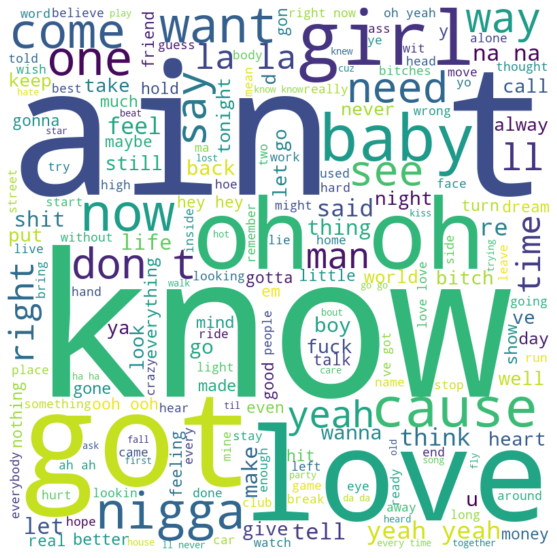

In [ ]:
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(text)

plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()